In [2]:
import torch
import torch.nn as nn
from transformers import (
    EarlyStoppingCallback, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, 
    TrainingArguments, Trainer, AutoConfig, AutoModelForCTC, Wav2Vec2PhonemeCTCTokenizer, AutoFeatureExtractor, Wav2Vec2Model, HubertModel, WavLMModel )
from datasets import load_from_disk
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr


/home/haeyoung/anaconda3/envs/s3prl38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# for general, freeze
class PronunciationScoringModel(nn.Module):
    def __init__(self, model_name, model_save_path=None):
        super().__init__()
        config = AutoConfig.from_pretrained(model_name)
        if 'wav2vec2' in model_name:
            self.model = Wav2Vec2Model.from_pretrained(model_name, config=config)
        elif 'hubert' in model_name:
            self.model = HubertModel.from_pretrained(model_name, config=config)
        elif 'wavlm' in model_name:
            self.model = WavLMModel.from_pretrained(model_name, config=config)
        else:
            raise ValueError(f"Unsupported model type for model name: {model_name}")
        self.score_predictor = nn.Linear(config.hidden_size, 4)  # Additional linear layer for scoring

    def forward(self, input_values):
        outputs = self.model(input_values=input_values)
        last_hidden_state = outputs.last_hidden_state
        scores = self.score_predictor(last_hidden_state.mean(dim=1))
        return scores

In [ ]:
class PronunciationScoringModel(nn.Module):
    def __init__(self, model_name, model_save_path=None):
        super().__init__()
        config = AutoConfig.from_pretrained(model_name)
        if 'wav2vec2' in model_name:
            self.model = Wav2Vec2Model.from_pretrained(model_name, config=config)
        elif 'hubert' in model_name:
            self.model = HubertModel.from_pretrained(model_name, config=config)
        elif 'wavlm' in model_name:
            self.model = WavLMModel.from_pretrained(model_name, config=config)
        else:
            raise ValueError(f"Unsupported model type for model name: {model_name}")
        self.score_predictor = nn.Linear(config.hidden_size, 4)  # Additional linear layer for scoring

    def forward(self, input_values, attention_mask=None):
        outputs = self.model(input_values=input_values, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            last_hidden_state = last_hidden_state * attention_mask
            pooled_output = last_hidden_state.sum(dim=1) / attention_mask.sum(dim=1)
        else:
            pooled_output = last_hidden_state.mean(dim=1)
        
        scores = self.score_predictor(pooled_output)
        return scores

In [ ]:
# for ctc
class PronunciationScoringModelforCTC(nn.Module):
    def __init__(self, model_name, model_save_path=None):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModelForCTC.from_pretrained(model_name)        
        self.score_predictor = nn.Linear(32, 4)
        
    def forward(self, input_values, labels=None, output_hidden_states=True, return_dict=True):
        outputs = self.model(input_values=input_values, 
                             output_hidden_states=output_hidden_states, 
                             return_dict=return_dict)

        logits = outputs.logits
        hidden_states = outputs.hidden_states[-1]
        pooled_output = logits.mean(dim=1)
        scores = self.score_predictor(pooled_output).squeeze(-1)
        return scores

In [ ]:
test_ds_path = "/data2/haeyoung/speechocean762/preprocess/speechocean_test_ds"
test_ds = load_from_disk(test_ds_path)

In [ ]:
model_name = "facebook/hubert-xlarge-ls960-ft"
model_save_path = "/data2/haeyoung/finetuned/hubert/ctc/09_hubert-xlarge-ls960-ft/model.safetensors"

model = PronunciationScoringModelforCTC(model_name)
model.load_state_dict(load_file(model_save_path))
model.to("cuda")
model.eval()
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)


Some weights of the model checkpoint at facebook/hubert-xlarge-ls960-ft were not used when initializing HubertForCTC: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-xlarge-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a dow

In [ ]:
def extract_scores(model, feature_extractor, batch):
    input_values = feature_extractor(batch["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to("cuda")
    with torch.no_grad():
        scores_pred  = model(input_values)
        scores_numpy = scores_pred.cpu().detach().numpy()
    return scores_numpy

def get_labels(batch):
    labels = np.zeros([4])
    labels[0] = batch['accuracy']
    labels[1] = batch['fluency']
    labels[2] = batch['prosodic']
    labels[3] = batch['total']
    
    return labels


def compute_metrics(preds, labels):
    mse = mean_squared_error(labels, preds, multioutput='raw_values')
    pcc = [np.corrcoef(labels[:, i], preds[:, i])[0, 1] if not np.isnan(np.corrcoef(labels[:, i], preds[:, i])[0, 1]) else 0 for i in range(preds.shape[1])]

    metrics = {}
    for i, (mse_val, pcc_val) in enumerate(zip(mse, pcc)):
        metrics[f"mse_{i}"] = mse_val
        metrics[f"pcc_{i}"] = pcc_val

    return metrics

In [8]:
# Extracting labels
labels = [get_labels(batch) for batch in tqdm(test_ds)]
all_labels = np.vstack(labels)


100%|██████████| 2500/2500 [00:01<00:00, 1460.22it/s]


In [9]:
# Extracting predictions
preds = [extract_scores(model, feature_extractor, batch) for batch in tqdm(test_ds)]
all_preds = np.vstack(preds)

100%|██████████| 2500/2500 [02:16<00:00, 18.32it/s]


In [10]:
# Compute metrics
metrics = compute_metrics(all_preds, all_labels)
print(metrics)

{'mse_0': 1.2567775938291068, 'pcc_0': 0.7198205834942565, 'mse_1': 0.8891688441197395, 'pcc_1': 0.7868296233943456, 'mse_2': 0.9278532557342168, 'pcc_2': 0.7799914775352885, 'mse_3': 1.1983669829057686, 'pcc_3': 0.732334741490399}


In [11]:
alldimension = metrics
alldimension

{'mse_0': 1.2567775938291068,
 'pcc_0': 0.7198205834942565,
 'mse_1': 0.8891688441197395,
 'pcc_1': 0.7868296233943456,
 'mse_2': 0.9278532557342168,
 'pcc_2': 0.7799914775352885,
 'mse_3': 1.1983669829057686,
 'pcc_3': 0.732334741490399}

In [12]:
features = pd.read_csv("sslfeatures_score.csv")
df = features

In [13]:
gen_w2v2_large_df = df[df['model_name'] == 'ctc_hb-xlarge-ls960-ft']
w2v2 = gen_w2v2_large_df
w2v2_X = w2v2.drop(['model_name', 'accuracy', 'fluency', 'prosodic', 'total'], axis=1)
fluency = w2v2[['fluency']]
prosodic = w2v2[['prosodic']]
accuracy = w2v2[['accuracy']]
total = w2v2[['total']]
Y = np.column_stack((accuracy, fluency, prosodic, total))

In [ ]:
w2v2_pca = PCA(n_components=3)
w2v2PCs = w2v2_pca.fit_transform(w2v2_X)
w2v2PCs_df= pd.DataFrame(data=w2v2PCs, columns = ['PC1', 'PC2', 'PC3'])
w2v2_pc1 = w2v2PCs[:, 0]
w2v2_pc2 = w2v2PCs[:, 1]
w2v2_pc3 = w2v2PCs[:, 2]
w2v2PCs_df['accuracy'] = accuracy.values
w2v2PCs_df['fluency'] = fluency.values
w2v2PCs_df['prosodic'] = prosodic.values
w2v2PCs_df['total'] = total.values
w2v2PCs_df

,PC1,PC2,PC3,accuracy,fluency,prosodic,total
0,-1.039381,0.339321,-0.048319,9.0,9.0,9.0,9.0
1,-0.805474,0.238884,-0.135666,7.0,9.0,9.0,7.0
2,-1.497520,0.533474,0.082138,9.0,9.0,9.0,9.0
3,-0.744761,0.335037,-0.227579,8.0,9.0,8.0,7.0
4,-1.024935,0.335701,-0.140469,9.0,9.0,9.0,9.0
...,...,...,...,...,...,...,...
2495,2.765855,1.124286,-0.056226,5.0,3.0,3.0,4.0
2496,1.502231,0.265825,-0.056515,6.0,6.0,5.0,5.0
2497,2.835760,1.061597,-0.016769,4.0,3.0,3.0,3.0
2498,2.964793,1.110857,0.043709,5.0,5.0,4.0,4.0


Some weights of the model checkpoint at facebook/hubert-xlarge-ls960-ft were not used when initializing HubertForCTC: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-xlarge-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a dow

PCC using PC1 Only: [-0.7308448373282381, 0.7711146588103379, 0.7685883814717602, 0.7397038861526471]
PCC using PC2 Only: [-0.024183902117156316, -0.11346974352616247, -0.11609537251094298, -0.011514863753598451]
PCC using PC3 Only: [0.020692396305651863, 0.12198080879812032, 0.09301462868705873, -0.0008076716461691464]
PCC using PC1 and PC2: [-0.6780164826272462, 0.5012297787056148, 0.7684718675430339, 0.7341922288130182]
PCC using PC1 and PC3: [-0.703191330733413, 0.7423677711187728, 0.7686416804354936, 0.7374034163732083]
PCC using PC2 and PC3: [-0.006116270560178877, 0.042722256181462456, -0.11592888774969691, -0.01097682481790245]
PCC using All PCs: [-0.6295007253314644, 0.5071303221647031, 0.7593248971966433, 0.7257599001365767]
PCC using Full 1024-D: [0.7198205834942565, 0.7868296233943456, 0.7799914775352885, 0.732334741490399]


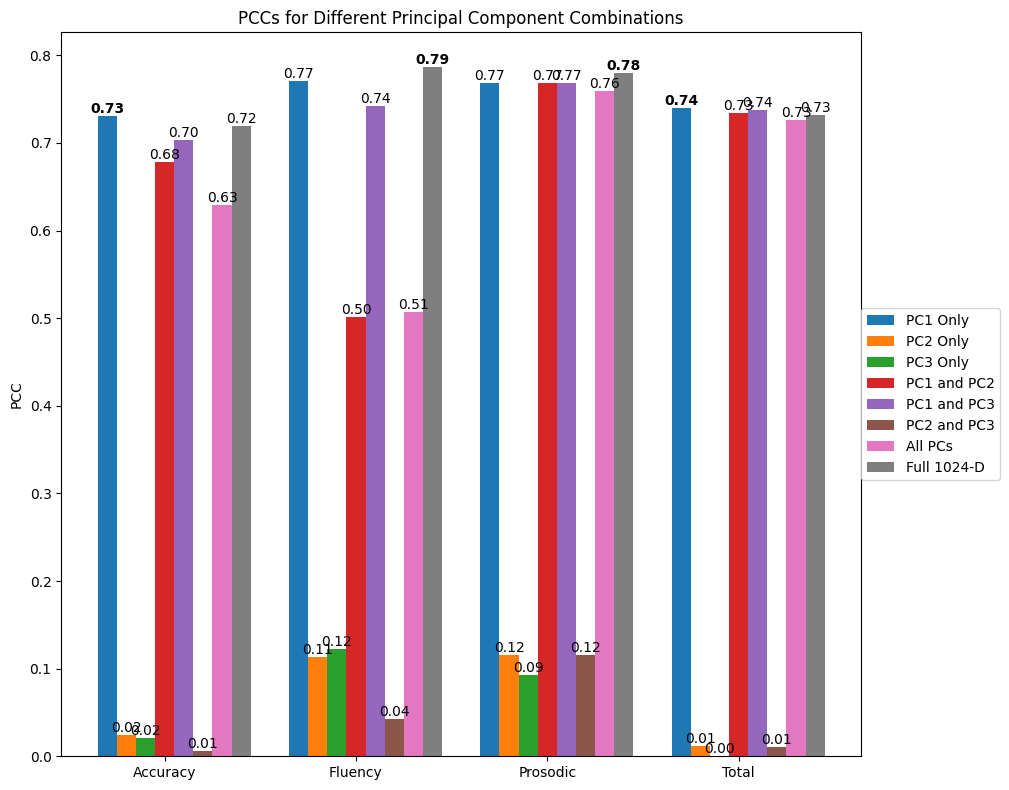

In [ ]:
# Scoring model using PCA-reduced embeddings
class PronunciationScoringModelForPC(nn.Module):
    def __init__(self, trained_model, num_components):
        # Initialize linear layer with input dimension equal to the number of PCA components
        super().__init__()
        self.score_predictor = nn.Linear(num_components, 4)
        self.score_predictor.weight.data = trained_model.score_predictor.weight[:, :num_components]
        self.score_predictor.bias.data = trained_model.score_predictor.bias

    def forward(self, pc_values):
        scores = self.score_predictor(pc_values).squeeze(-1)
        return scores
    
# Load pretrained model
model_name = "facebook/hubert-xlarge-ls960-ft"
model_save_path = "/data2/haeyoung/finetuned/hubert/ctc/09_hubert-xlarge-ls960-ft/model.safetensors"
trained_model = PronunciationScoringModelforCTC(model_name)
trained_model.load_state_dict(load_file(model_save_path))
trained_model.to("cuda")
trained_model.eval()

# Initialize models using PCA-reduced embeddings
model_pc1 = PronunciationScoringModelForPC(trained_model, 1)  # Using 1 principal component
model_pc1.to("cuda")
model_pc1.eval()

model_pc2 = PronunciationScoringModelForPC(trained_model, 2)  # Using 2 principal components
model_pc2.to("cuda")
model_pc2.eval()

model_pc3 = PronunciationScoringModelForPC(trained_model, 3)  # Using all 3 principal components
model_pc3.to("cuda")
model_pc3.eval()

# Predict and compute PCC for PCA inputs
def predict_and_evaluate(model, pc_values, targets):
    with torch.no_grad():
        pc_values_tensor = torch.tensor(pc_values, dtype=torch.float32).to("cuda")
        scores = model(pc_values_tensor)
        predictions = scores.cpu().detach().numpy()
        pcc_values = []
        for i in range(targets.shape[1]):
            pcc, _ = pearsonr(predictions[:, i], targets[:, i])
            pcc_values.append(pcc)
        return pcc_values
    

# Compute PCC for each PCA component combination
results = {}
results['PC1 Only'] = predict_and_evaluate(model_pc1, w2v2_pc1.reshape(-1, 1), Y)
results['PC2 Only'] = predict_and_evaluate(model_pc1, w2v2_pc2.reshape(-1, 1), Y)
results['PC3 Only'] = predict_and_evaluate(model_pc1, w2v2_pc3.reshape(-1, 1), Y)

results['PC1 and PC2'] = predict_and_evaluate(model_pc2, np.column_stack((w2v2_pc1, w2v2_pc2)), Y)
results['PC1 and PC3'] = predict_and_evaluate(model_pc2, np.column_stack((w2v2_pc1, w2v2_pc3)), Y)
results['PC2 and PC3'] = predict_and_evaluate(model_pc2, np.column_stack((w2v2_pc2, w2v2_pc3)), Y)

results['All PCs'] = predict_and_evaluate(model_pc3, w2v2PCs, Y)

# Original 1024-D
metrics = {'mse_0': 1.2567775938291068, 'pcc_0': 0.7198205834942565, 'mse_1': 0.8891688441197395, 'pcc_1': 0.7868296233943456, 'mse_2': 0.9278532557342168, 'pcc_2': 0.7799914775352885, 'mse_3': 1.1983669829057686, 'pcc_3': 0.732334741490399}
results['Full 1024-D'] = [metrics[f'pcc_{i}'] for i in range(4)]


for key, value in results.items():
    print(f'PCC using {key}: {value}')

labels = ['Accuracy', 'Fluency', 'Prosodic', 'Total']
pcc_keys = list(results.keys())

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(labels))

max_values = np.max([[abs(results[key][j]) for key in pcc_keys] for j in range(len(labels))], axis=1)

for i, key in enumerate(pcc_keys):
    pcc_values = results[key]
    bars = ax.bar(x + i * 0.1, [abs(v) for v in pcc_values], width=0.1, label=key)
    for j, v in enumerate(pcc_values):
        fontweight = 'bold' if abs(v) == max_values[j] else 'normal'
        ax.text(x[j] + i * 0.1, abs(v), f"{abs(v):.2f}", ha='center', va='bottom', fontweight=fontweight)

ax.set_ylabel('PCC')
ax.set_title('PCCs for Different Principal Component Combinations')
ax.set_xticks(x + 0.3)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()